In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

tf.config.threading.set_intra_op_parallelism_threads(64)
tf.config.threading.set_inter_op_parallelism_threads(64)

# Load the data
X = pd.read_csv('predict.csv')
y = pd.read_csv('response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include="number")  # Remove 'statecounty'

# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include='number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2)

In [11]:
#y_train = y_train.fillna(y_train.mean())

In [12]:
X

,Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020,Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020,Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_With_Health_Insurance_ACS2016_20,Population_Without_Health_Insurance_ACS2016_20,Percent_Population_Without_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_18yrs_And_Under_With_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,PercentPopulation_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,...,Percent_of_Farmers_Market_Accept_WIC_USDA_2018,Number_of_Farmers_Market_Accept_WIC_Cash_USDA_2018,Percent_of_Farmers_Market_Accept_SNAP_USDA_2018.1,Number_of_Farmers_Market_Accept_SFMNP_USDA_2018,Percent_of_Farmers_Market_Accept_SFMNP_USDA_2018,Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016,NHPI_Percent_Difference_From_Overall_Median_Household_Income_In_the_Past_Year_ACS2017_21,NHPI_Percent_Difference_From_Overall_Median_Family_Income_In_the_Past_Year_ACS2017_21,NHPI_Percent_Difference_From_Overall_Per_Capita_Income_In_the_Past_Year_ACS2017_21,NHPI_Percent_Difference_From_Overall_Median_Nonfamily_Household_Income_In_the_Past_Year_ACS2017_21
0,-0.003959,-0.241885,-0.145190,-0.145337,-0.128967,-0.309206,-0.136846,-0.132249,-0.179008,-0.707861,...,-0.523101,-0.246622,-0.583061,-0.305169,-0.568823,-0.130152,NaN,NaN,NaN,NaN
1,0.174980,0.033511,0.344434,0.342450,0.325466,-0.005645,0.308564,0.311404,0.213659,-0.246464,...,-0.523101,-0.246622,-0.583061,1.080557,2.417396,0.275357,NaN,NaN,NaN,NaN
2,-0.406572,-0.173979,-0.243764,-0.247814,-0.184744,0.223494,-0.241785,-0.240813,-0.213419,-0.613265,...,-0.523101,-0.246622,0.965496,0.387694,0.924287,-0.292356,NaN,NaN,NaN,NaN
3,0.599959,2.330994,-0.247921,-0.250789,-0.198358,-0.095734,-0.249729,-0.248016,-0.230624,-0.898984,...,-0.523101,-0.246622,-0.583061,-0.305169,-0.568823,-0.265322,NaN,NaN,NaN,NaN
4,-0.406572,-0.660638,-0.136921,-0.140896,-0.089560,0.096194,-0.134622,-0.133179,-0.131788,-0.373879,...,2.732424,-0.246622,-0.583061,0.041263,2.417396,-0.184220,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,-0.406572,0.282499,-0.281052,-0.285859,-0.211859,0.912870,-0.280109,-0.284816,-0.163332,2.214961,...,-0.523101,-0.246622,-0.583061,-0.305169,-0.568823,-0.292356,NaN,NaN,NaN,NaN
3138,-0.406572,-0.275838,-0.180068,-0.186427,-0.108321,0.440882,-0.159596,-0.167294,-0.020909,0.695634,...,-0.523101,-0.246622,-0.583061,-0.305169,-0.568823,-0.130152,NaN,NaN,NaN,NaN
3139,0.555225,0.678617,-0.240178,-0.244867,-0.176193,0.372336,-0.254757,-0.258156,-0.161229,0.711078,...,-0.523101,-0.246622,0.449310,-0.305169,-0.568823,0.059086,NaN,NaN,NaN,NaN
3140,-0.406572,-0.502191,-0.249632,-0.254013,-0.187247,0.337084,-0.234810,-0.237159,-0.159891,0.232307,...,-0.523101,-0.246622,-0.583061,-0.305169,-0.568823,-0.238288,NaN,NaN,NaN,NaN


In [13]:
print(X_train.isnull().sum())
print(X_train.isin([np.inf, -np.inf]).sum())
print(y_train.isnull().sum())


Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020                                          0
Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020                                           0
Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20                            0
Population_With_Health_Insurance_ACS2016_20                                                           0
Population_Without_Health_Insurance_ACS2016_20                                                        0
                                                                                                     ..
Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016                                   0
NHPI_Percent_Difference_From_Overall_Median_Household_Income_In_the_Past_Year_ACS2017_21              0
NHPI_Percent_Difference_From_Overall_Median_Family_Income_In_the_Past_Year_ACS2017_21                 0
NHPI_Percent_Difference_From_Overall_Per_Capita_Income_In_the_Pa

In [14]:
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    diff = tf.boolean_mask(y_true - y_pred, mask)  # Ignore NaNs
    return tf.reduce_mean(tf.square(diff))

def build_model(hp):
    model = tf.keras.models.Sequential()
    input_dim = X_train.shape[1]  # Ensure correct input dimension
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 2, 3)):  # Between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Adjust range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    # Output layer matching y_train shape
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))

    # Compile model with masked loss
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss=masked_loss,
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [15]:
# tuner.results_summary()


In [16]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose = 1)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

Trial 20 Complete [00h 00m 17s]
val_mae: 0.6481512188911438

Best val_mae So Far: 0.6399234235286713
Total elapsed time: 00h 05m 22s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7943 - mae: 0.6984  


Best Model Test Loss: 0.8598883152008057, Test MAE: 0.696673572063446


In [17]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)
assert list(X_train.columns) == list(X_test.columns), "Mismatch in feature columns"


In [22]:
# Swapping PermutationExplainer for GradientExplainer
X_train_np = X_train.values  # Convert X_train to NumPy array
X_test_np = X_test.values    # Convert X_test to NumPy array

# Initialize GradientExplainer
explainer = shap.GradientExplainer(best_model, X_train_np)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_np)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(629, 912))']
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 912))']
  warnings.warn(msg)


In [23]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(629, 912, 1)


In [24]:
shap_values = np.squeeze(shap_values)  

import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
                                               feature  importance
242  Black_AA_Percent_Single_Race_Female_65yrs_And_...    0.022835
206  Percent_Female_16_64yrs_Old_Not_In_Labor_Force...    0.021086
336  Percent_Population_In_Service_Occupations_ACS2...    0.018480
782  Percent_Population_Access_To_Exercise_Opportun...    0.018377
352  Percent_Male_Population_In_Production_Transpor...    0.017570
..                                                 ...         ...
479  NHPI_Single_Race_Female_In_Natural_Resources_C...    0.000422
840  NHPI_Single_Race_Occupied_Housing_With_More_th...    0.000336
87   NHPI_Population_In_Production_Transportation_A...    0.000303
308  NHPI_Percent_Single_Race_Population_65yrs_And_...    0.000278
329  NHPI_Single_Race_Female_65yrs_And_Over_In_Labo...    0.000261

[912 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


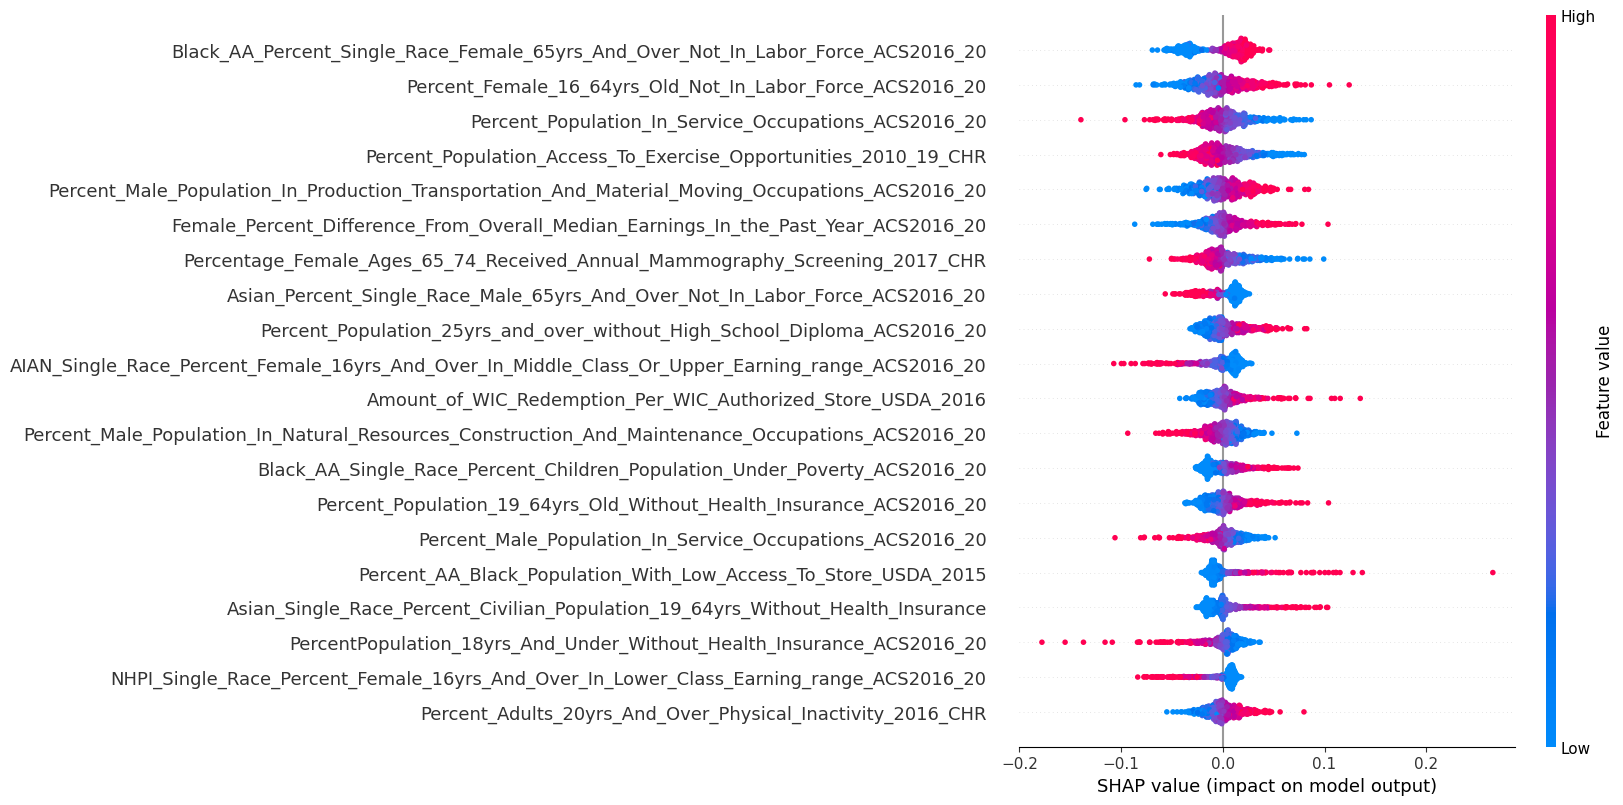

In [25]:
import shap
shap.summary_plot(shap_values, X_test, max_display=20)  # Adjust max_display as needed
